#### 📊 compare models.ipynb

In [1]:
import sys, os
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [2]:
from cifar10_classifier import CIFAR10Classifier

from utils import build_comparison_table, plot_model_comparison, plot_confusion_matrix
from utils import evaluate_all_models_on_test

from utils import plot_val_vs_test_acc, plot_dropout_vs_overfit, plot_efficiency, plot_group_accuracy, print_per_class_accuracy

In [3]:
models_path = os.path.join(project_root,"models")

,Model,Type,Architecture,Epoch (best),Train Acc,Val Acc,Overfit Gap,Val Loss,Avg Epoch Time (s),LR,Dropout,Optimizer,Converged by Epoch,Stability (val acc)
0,cnn_advanced,CNN,"conv: 3, fc: 2",12,0.835000,0.744300,0.090700,0.804000,24.030000,0.000500,"[0.5, 0.3]",Adam,5,0.003800
1,cnn_64_128_256_fc_512,CNN,"conv: 3, fc: 1",16,0.978700,0.744200,0.234500,1.445000,24.460000,0.000500,[0.4],Adam,3,0.002400
2,cnn_test,CNN,"conv: 2, fc: 2",12,0.847100,0.722200,0.124900,0.881400,24.420000,0.001000,"[0.3, 0.3]",Adam,3,0.003900
3,fc_1024_512_256,FC,fc: 3,28,0.703400,0.578700,0.124700,1.268500,23.610000,0.010000,"[0.3, 0.3, 0.3]",SGD,6,0.006100
4,fc_2048_6layers,FC,fc: 6,30,0.768200,0.571100,0.197100,1.412500,17.280000,0.001000,"[0.3, 0.3, 0.3, 0.3, 0.3, 0.3]",Adam,7,0.003100
5,fc_test,FC,fc: 3,21,0.710500,0.565400,0.145100,1.358600,27.790000,0.010000,"[0.3, 0.3, 0.3]",Adam,5,0.003600
6,torch_2048_6,FC,fc: 6,26,0.719500,0.562700,0.156800,1.366900,23.410000,0.010000,"[0.3, 0.3, 0.3, 0.3, 0.3, 0.3]",Adam,8,0.003000
7,test_model,FC,fc: 6,1,0.304800,0.377700,-0.072900,1.727400,22.030000,0.010000,"[0.3, 0.3, 0.3, 0.3, 0.3, 0.3]",Adam,1,0.000000


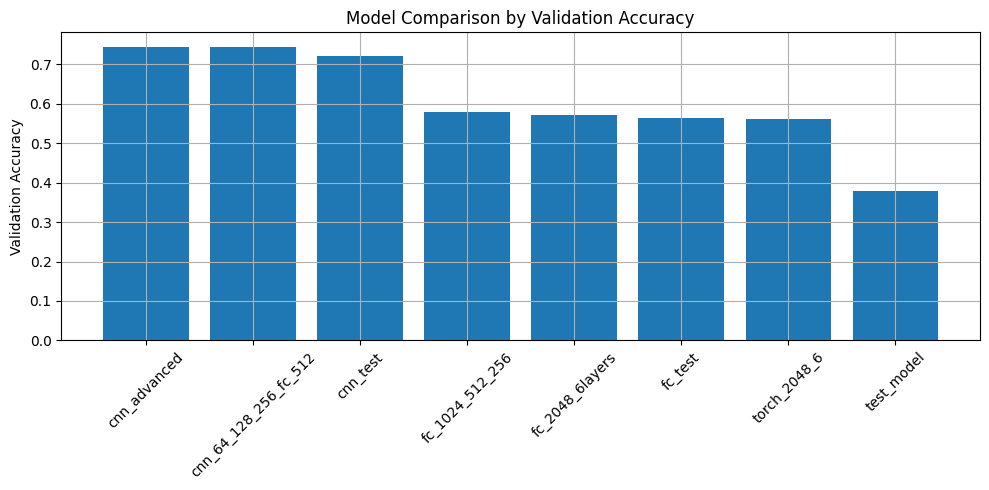

In [4]:

df_models = build_comparison_table(models_dir=models_path).sort_values(by="Val Acc", ascending=False)
styled_df_models = df_models.style.bar(subset=["Val Acc", "Train Acc", "Overfit Gap", "Stability (val acc)"], color='lightblue')
display(styled_df_models)

plot_model_comparison(df_models)

In [5]:
test_results, class_names = evaluate_all_models_on_test(models_dir=models_path, force=False, save_predictions=True)

for model_name, metrics in test_results.items():
    if model_name in df_models["Model"].values:
        df_models.loc[df_models["Model"] == model_name, "Test Acc"] = round(metrics["accuracy"], 4)
        df_models.loc[df_models["Model"] == model_name, "Test Loss"] = round(metrics["loss"], 4)

------------------------------------------------------------
Evaluating cnn_64_128_256_fc_512...
------------------------------------------------------------
✅ Test results already exist for cnn_64_128_256_fc_512.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10-Torch-Classifier\models\cnn_64_128_256_fc_512\cnn_64_128_256_fc_512_test.json
------------------------------------------------------------
Evaluating cnn_advanced...
------------------------------------------------------------
✅ Test results already exist for cnn_advanced.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10-Torch-Classifier\models\cnn_advanced\cnn_advanced_test.json
------------------------------------------------------------
Evaluating cnn_test...
------------------------------------------------------------
✅ Test results already exist for cnn_test.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10-Torch-Classifier\models\cnn_test\cnn_test_test.json
--

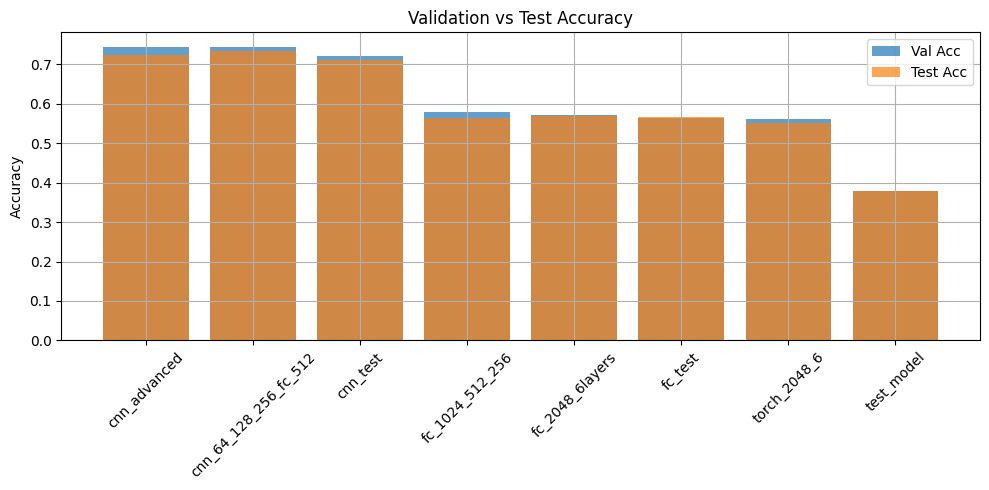

In [6]:
plot_val_vs_test_acc(df_models)

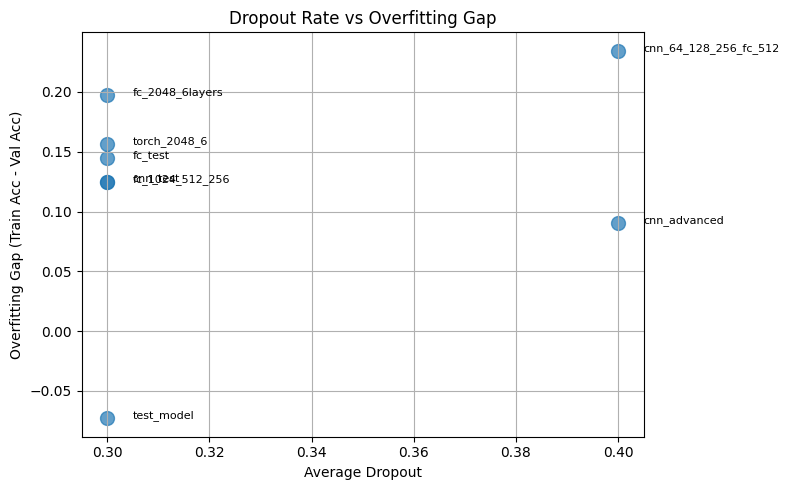

In [7]:
df_models["Dropout Avg"] = df_models["Dropout"].apply(lambda d: np.mean(eval(d)) if isinstance(d, str) else np.nan)
plot_dropout_vs_overfit(df_models)

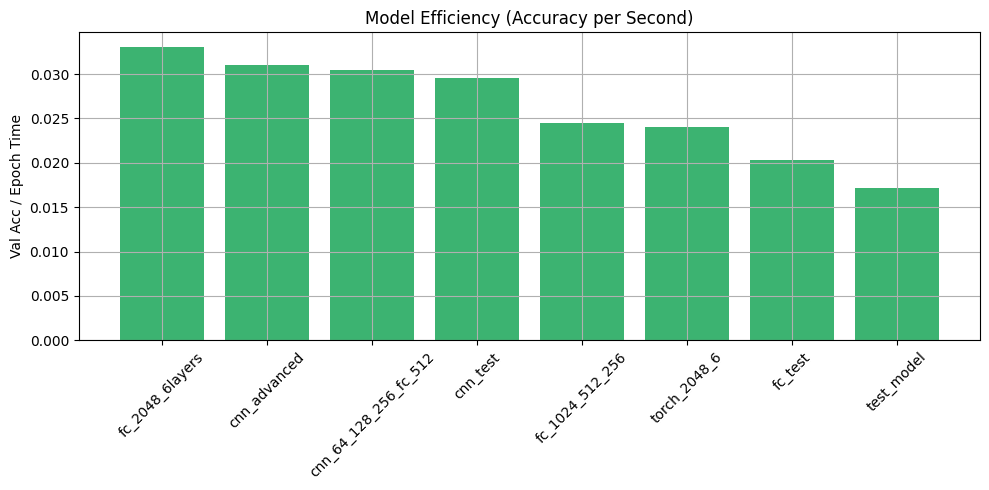

In [8]:
df_models["Efficiency"] = df_models["Val Acc"] / df_models["Avg Epoch Time (s)"]

plot_efficiency(df_models)

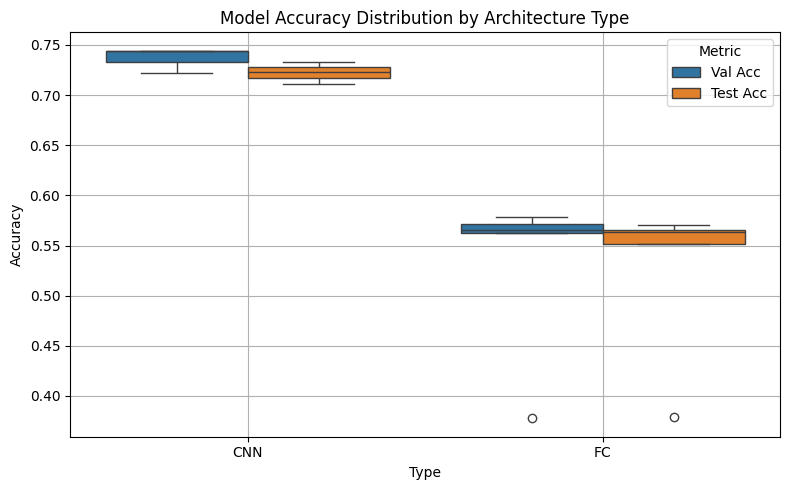

In [9]:
plot_group_accuracy(df_models)

In [ ]:
model1_name = "cnn_advanced"
model2_name = "fc_2048_6layers"

# confusion matrix
plot_confusion_matrix(test_results[model1_name]["y_pred"],
                    test_results[model1_name]["y_true"],
                    class_names=class_names,
                    normalize=True)

plot_confusion_matrix(test_results[model2_name]["y_pred"],
                    test_results[model2_name]["y_true"],
                    class_names=class_names,
                    normalize=True)

# reports
print("📊 CNN — per-class accuracy:")
print_per_class_accuracy(test_results[model1_name]["y_true"],
                    test_results[model1_name]["y_pred"],
                    class_names)

print("📊 FC — per-class accuracy:")
print_per_class_accuracy(test_results[model2_name]["y_true"],
                    test_results[model2_name]["y_pred"],
                    class_names)


TypeError: object of type 'NoneType' has no len()

<Figure size 800x600 with 0 Axes>